# [SWCON253] Machine Learning
Teaching Assistant: Yeongwoong Kim (duddnd7575@khu.ac.kr)

Professor: Jinwoo Choi (jinwoochoi@khu.ac.kr)

---

# P3:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

**1. 다음은 변경 가능한 부분입니다.**
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size
- 각 hidden layer의 neuron 개수

**2. 그러나 다음 사항은 변경하지 마세요.**
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

**3. layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요.**

**4. 수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.**

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [211]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [212]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [179]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [180]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [181]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [182]:
############################################################
# 변경 가능한 셀
############################################################

# BATCH_SIZE = 60000을 사용하면 Full-Batch 학습
# BATCH_SIZE = 1을 사용하면 Online 학습
# BATCH_SIZE = N (1 < N < 60000) 을 사용하면 Mini-batch 학습
BATCH_SIZE = 128

In [183]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

특히, Label data의 경우 One-hot vector encoding 되기 전의 형태의 class label 정보입니다.

In [184]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print(f'Image data shape: \t {x.shape}')
        print(f'Label data shape: \t {y.shape}')
        print(y)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Image data shape: 	 torch.Size([128, 1, 28, 28])
Label data shape: 	 torch.Size([128])
tensor([0, 8, 3, 5, 2, 5, 5, 4, 4, 5, 0, 9, 9, 4, 2, 5, 7, 2, 7, 7, 4, 3, 7, 8,
        1, 2, 3, 8, 7, 2, 4, 2, 9, 6, 2, 1, 4, 8, 3, 5, 0, 9, 5, 6, 5, 4, 8, 4,
        8, 6, 7, 3, 5, 0, 7, 7, 7, 3, 8, 5, 5, 4, 1, 2, 6, 3, 7, 5, 7, 0, 4, 6,
        0, 9, 7, 1, 5, 8, 2, 8, 5, 0, 4, 3, 5, 4, 5, 8, 5, 1, 8, 9, 3, 7, 7, 5,
        4, 7, 7, 5, 3, 5, 0, 8, 2, 2, 0, 3, 4, 2, 4, 2, 0, 0, 0, 9, 3, 4, 6, 2,
        0, 1, 1, 7, 5, 2, 1, 9])


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [199]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2,num_hidden_3, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes # 10 
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
#         self.linear_4 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        
        # <your code> to add layer
        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x)
        out = F.relu(out)
        
        out = self.linear_2(out)
        out = F.relu(out)
        
        out = self.linear_3(out)
        out = F.relu(out)
        
              
#         out = self.linear_3(out)
#         out = torch.relu(out)
        
        # <your code> to set the layer and the activation function
        
        logits = self.linear_out(out)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        # 다만, 이후 사용할 F.cross_entropy() 함수 내부에 softmax가 이미 구현되어 있기 때문에
        # Loss function 계산 시에는 self.softmax()를 통과하기 전의 logits 값을 이용하게 됩니다.
        probas = self.softmax(logits)
        return logits, probas

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4) Training

**Cross entropy loss function 사용 시 주의점**

- 모델의 출력인 logits, probas의 차원은 [BATCH_SIZE, num_classes] 형태지만, 정답 Label인 targets 변수의 차원은 [BATCH_SIZE] 입니다. (ex, [1, 3, 2, 4, 9, ..., 3])


- 일반적으로 Cross Entropy Loss를 계산하기 위해서는 targets에 one-hot vector encoding을 수행해주어야 하지만, F.cross_entropy() 함수는 이를 내부적으로 수행해줍니다.


- 또한, F.cross_entropy() 함수 내부적으로 softmax 함수를 이용하기 때문에, 모델의 출력 중 probas 값이 아닌 logits 값을 이용하여 Loss function을 계산합니다.


- 구현 상세는 pytorch documents에서 확인할 수 있습니다. (https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy)

In [216]:
############################################################
# 변경 가능한 셀
############################################################

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=512,
            num_hidden_2=256,
            num_hidden_3=128,
    
            num_classes=10)

model = model.to(DEVICE)


### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

NUM_EPOCHS = 40 # 변경 가능
############################################################

### 아래는 변경 불가능
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        
        # Loss 계산 시에는 logits 이용
        cross_entropy += F.cross_entropy(logits, targets).item()
        
        # 추론 시에는 probas 이용
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.cpu().float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/040 | Batch 000/468 | Cost: 2.2958
Epoch: 001/040 | Batch 040/468 | Cost: 2.2710
Epoch: 001/040 | Batch 080/468 | Cost: 2.2277
Epoch: 001/040 | Batch 120/468 | Cost: 2.1856
Epoch: 001/040 | Batch 160/468 | Cost: 2.1001
Epoch: 001/040 | Batch 200/468 | Cost: 1.9380
Epoch: 001/040 | Batch 240/468 | Cost: 1.6889
Epoch: 001/040 | Batch 280/468 | Cost: 1.5231
Epoch: 001/040 | Batch 320/468 | Cost: 1.3166
Epoch: 001/040 | Batch 360/468 | Cost: 1.2070
Epoch: 001/040 | Batch 400/468 | Cost: 1.1690
Epoch: 001/040 | Batch 440/468 | Cost: 1.0426
Epoch: 001/040 Train Acc.: 67.51% | Test Acc.: 67.38%
Time elapsed: 0.21 min
Epoch: 002/040 | Batch 000/468 | Cost: 0.9099
Epoch: 002/040 | Batch 040/468 | Cost: 1.0017
Epoch: 002/040 | Batch 080/468 | Cost: 0.9984
Epoch: 002/040 | Batch 120/468 | Cost: 0.8027
Epoch: 002/040 | Batch 160/468 | Cost: 0.7830
Epoch: 002/040 | Batch 200/468 | Cost: 0.6900
Epoch: 002/040 | Batch 240/468 | Cost: 0.7597
Epoch: 002/040 | Batch 280/468 | Cost: 0.8197
Epo

Epoch: 014/040 | Batch 040/468 | Cost: 0.3903
Epoch: 014/040 | Batch 080/468 | Cost: 0.3688
Epoch: 014/040 | Batch 120/468 | Cost: 0.2918
Epoch: 014/040 | Batch 160/468 | Cost: 0.5037
Epoch: 014/040 | Batch 200/468 | Cost: 0.3584
Epoch: 014/040 | Batch 240/468 | Cost: 0.4216
Epoch: 014/040 | Batch 280/468 | Cost: 0.2791
Epoch: 014/040 | Batch 320/468 | Cost: 0.2647
Epoch: 014/040 | Batch 360/468 | Cost: 0.2862
Epoch: 014/040 | Batch 400/468 | Cost: 0.3474
Epoch: 014/040 | Batch 440/468 | Cost: 0.4616
Epoch: 014/040 Train Acc.: 86.47% | Test Acc.: 85.07%
Time elapsed: 2.89 min
Epoch: 015/040 | Batch 000/468 | Cost: 0.3128
Epoch: 015/040 | Batch 040/468 | Cost: 0.3222
Epoch: 015/040 | Batch 080/468 | Cost: 0.3516
Epoch: 015/040 | Batch 120/468 | Cost: 0.4232
Epoch: 015/040 | Batch 160/468 | Cost: 0.4216
Epoch: 015/040 | Batch 200/468 | Cost: 0.3729
Epoch: 015/040 | Batch 240/468 | Cost: 0.3115
Epoch: 015/040 | Batch 280/468 | Cost: 0.3565
Epoch: 015/040 | Batch 320/468 | Cost: 0.3017
Epo

Epoch: 027/040 | Batch 080/468 | Cost: 0.3353
Epoch: 027/040 | Batch 120/468 | Cost: 0.2552
Epoch: 027/040 | Batch 160/468 | Cost: 0.3070
Epoch: 027/040 | Batch 200/468 | Cost: 0.3215
Epoch: 027/040 | Batch 240/468 | Cost: 0.2846
Epoch: 027/040 | Batch 280/468 | Cost: 0.3659
Epoch: 027/040 | Batch 320/468 | Cost: 0.2526
Epoch: 027/040 | Batch 360/468 | Cost: 0.3733
Epoch: 027/040 | Batch 400/468 | Cost: 0.3232
Epoch: 027/040 | Batch 440/468 | Cost: 0.2424
Epoch: 027/040 Train Acc.: 88.77% | Test Acc.: 86.81%
Time elapsed: 5.58 min
Epoch: 028/040 | Batch 000/468 | Cost: 0.3035
Epoch: 028/040 | Batch 040/468 | Cost: 0.3861
Epoch: 028/040 | Batch 080/468 | Cost: 0.2798
Epoch: 028/040 | Batch 120/468 | Cost: 0.3033
Epoch: 028/040 | Batch 160/468 | Cost: 0.3046
Epoch: 028/040 | Batch 200/468 | Cost: 0.3141
Epoch: 028/040 | Batch 240/468 | Cost: 0.3329
Epoch: 028/040 | Batch 280/468 | Cost: 0.3330
Epoch: 028/040 | Batch 320/468 | Cost: 0.2805
Epoch: 028/040 | Batch 360/468 | Cost: 0.2803
Epo

Epoch: 040/040 | Batch 120/468 | Cost: 0.2321
Epoch: 040/040 | Batch 160/468 | Cost: 0.2481
Epoch: 040/040 | Batch 200/468 | Cost: 0.2538
Epoch: 040/040 | Batch 240/468 | Cost: 0.3080
Epoch: 040/040 | Batch 280/468 | Cost: 0.2714
Epoch: 040/040 | Batch 320/468 | Cost: 0.2991
Epoch: 040/040 | Batch 360/468 | Cost: 0.1743
Epoch: 040/040 | Batch 400/468 | Cost: 0.2294
Epoch: 040/040 | Batch 440/468 | Cost: 0.3152
Epoch: 040/040 Train Acc.: 90.99% | Test Acc.: 88.09%
Time elapsed: 8.31 min
Total Training Time: 8.31 min


## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

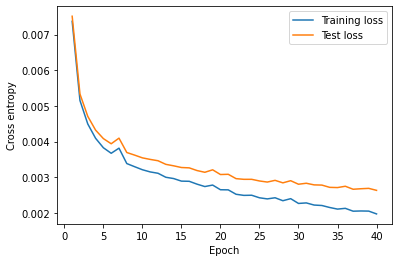

In [217]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

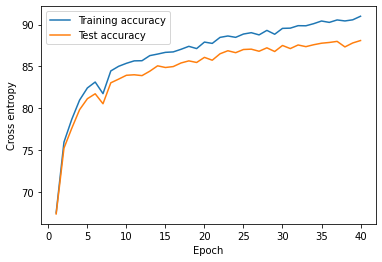

In [218]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [219]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.09%


## 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training:  90.99%
- Test 88.09%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요

[제안하는 방법 적기]
트레이닝 횟수가 늘어날 수록 Test accuracy와 Trainging accuracy간의 간극이 점점 늘어나는 것을 확인할 수 있다.
따라서 트레이닝 횟수 (epoch) 수를 적정수준으로 유지해야 한다.

예를 들면, 

- batch size를 256으로 변경
- 두개의 hidden layers의 activation을 relu로 변경
- learning rate를 0.2로 변경

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

[답변작성]
은닉층 수가 늘어날 수록 accuracy가 향상되는 부분을 느낄수 있었다. 이는 좀 더 많은 가중치를 상세하게 부여할 수 있기 때문이다.
다만 overfitting에 대한 문제가 생길 우려가 있으며, 계산과정에 많은 시간이 소요되었다.


**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

[답변작성]
Epoch 수 늘리기 : 반복되는 트레이닝을 통하여 점점 더 성능이 향상되었다. 가중치 수정을 충분하게 할 수 있게 되었기 때문이다.

Learning Rate 감소 : lr을 0.02까지 감소시켰는데, loss 함수의 수렴의 정확도를 높일 수 있었다.

활성함수를 sigmoid 에서 relu 함수로 교체

hidden layer 노드 수 증가(10->10->10)을 (512->256->128)로 입력 노드수(28*28)에서 서서히 감소할 수 있도록 하였다.

In [1]:
import cplex

ImportError: dlopen(/Users/kwonsebin/opt/anaconda3/lib/python3.9/site-packages/cplex/_internal/py39_cplex2211.so, 0x0002): tried: '/Users/kwonsebin/opt/anaconda3/lib/python3.9/site-packages/cplex/_internal/py39_cplex2211.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/kwonsebin/opt/anaconda3/lib/python3.9/site-packages/cplex/_internal/py39_cplex2211.so' (no such file), '/Users/kwonsebin/opt/anaconda3/lib/python3.9/site-packages/cplex/_internal/py39_cplex2211.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))